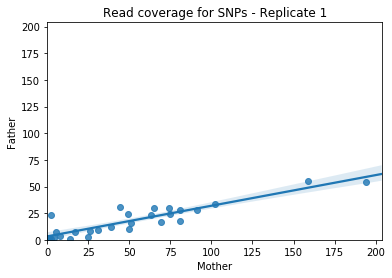

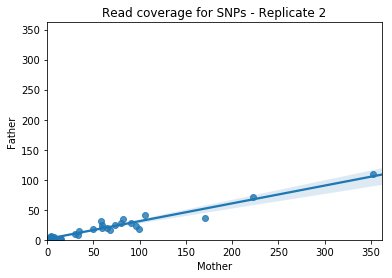

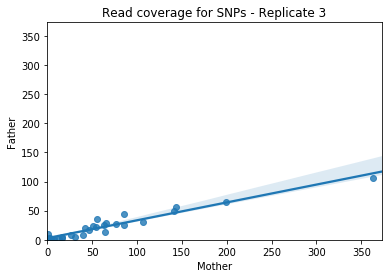

In [3]:
import numpy as np
import vcf
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def count_reads(chrm, view_start, view_end, samfile, vcf_reader):
	mother = []
	father = []
	coordinates = []
	mother_is_ref = []

	for Record in vcf_reader.fetch(chrm, view_start, view_end):  # doctest: +SKIP
		genotype = Record.genotype(individual_name)['GT']

		# not phased
		if not ("|" == genotype[1]) or genotype[0]==genotype[2]:
			# print (genotype)
			continue

		# multi nucleotide polymorphism
		one_nc_snp = True
		for var in Record.ALT:
			if len(var) > 1:
				one_nc_snp = False
		if len(Record.REF) > 1 or not one_nc_snp:
			# print ("skip")
			continue

		snp = Record.POS
		mp_cnt = {}

		bo_first = True

		for pileupcolumn in samfile.pileup(chrm, snp - 1, snp):
			if bo_first:
				bo_first = False
				#print(Record.CHROM, Record.POS, Record.ID, Record.REF, Record.ALT, Record.genotype(individual_name)['GT'])
			if pileupcolumn.pos == snp - 1:
				for pileupread in pileupcolumn.pileups:
					if not pileupread.is_del and pileupread.alignment.mapping_quality >= 30:
						mp_cnt[pileupread.alignment.query_sequence[pileupread.query_position]] = mp_cnt.get(
							pileupread.alignment.query_sequence[pileupread.query_position], 0) + 1

		# different genotype
		alt = [str(var) for var in Record.ALT]
		if set(mp_cnt.keys()) != set(alt + [Record.REF]):
			# print (set (mp_cnt.keys()), alt + [Record.REF])
			# print ('different sets of variants')
			continue

		# print (mp_cnt)
		coordinates += [Record.POS]
		if genotype[0] == "0":
			mother += [mp_cnt[Record.REF]]
			father += [mp_cnt[str(Record.ALT[0])]]
			mother_is_ref += [True]
		else:
			father += [mp_cnt[Record.REF]]
			mother += [mp_cnt[str(Record.ALT[0])]]
			mother_is_ref += [False]
	samfile.close()



	m = np.array(mother, dtype=np.float)
	f = np.array(father, dtype=np.float)
	c = np.array(coordinates, dtype=np.int)
	r = np.array(mother_is_ref, dtype=np.bool)
	return m, f, c, r



def set_inputfiles():
	RNAseqbams = ['L18098Aligned.sortedByCoord.out.bam',  'L18099Aligned.sortedByCoord.out.bam',  'L18100Aligned.sortedByCoord.out.bam']
	path = '/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/'
	bams = [ pysam.AlignmentFile(path + f) for f in RNAseqbams]
	vcf_reader = vcf.Reader(open(
		'/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/brusco_uwcmg_eho_1.HF.final.phased.vcf.gz'))
	individual_name = '176126'
	names = ['0','1','2']
	return  bams,vcf_reader, names, individual_name






sams,vcf_reader,names,individual_name = set_inputfiles()


for inx_replicate in range(3):

    samfile = sams[inx_replicate]

    genomic_region = 0
    if genomic_region == 0:
        interval_string = 'X:1-155270560'
        interval_string = 'X:153270560-155270560'
        open_left_region = 0
        open_right_region = 0
        SV_type = "???"
        sample_name = "---"


    interval = interval_string.replace(",",'')
    chrm = interval.split(":")[0]
    sv_start = int(interval.split(":")[1].split("-")[0])
    sv_end = int(interval.split(":")[1].split("-")[1])
    view_start = sv_start - open_left_region
    view_end = sv_end + open_right_region




    sample = sample_name + ", " + SV_type + "\n" + interval_string





    m,f,c,r= count_reads(chrm,view_start,view_end,samfile,vcf_reader)


    d = {'Mother':m, 'Father':f,'Coordinate':c,'MotherIsRef':r}
    df = pd.DataFrame(d)
    ax = sns.regplot(x="Mother", y="Father",  data=df)
    #ax = sns.scatterplot(x="Mother", y="Father",  style="MotherIsRef", data=df,alpha=0.3,hue='MotherIsRef')
    mx = int ( max ( df['Mother'].max() , df['Father'].max() ))
    ax.set_xlim((0,mx+ 10 ))
    ax.set_ylim((0,mx+ 10 ))
    ax.set_title("Read coverage for SNPs - Replicate " + str (inx_replicate + 1 ))
    plt.show()

